# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import *

In [2]:
import os
### this is for running in local ###
try:
    os.environ['HTTP_PROXY']='http://185.46.212.90:80'
    os.environ['HTTPS_PROXY']='http://185.46.212.90:80'
    print ("proxy_exported")
except:
    None

proxy_exported


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(0,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           2,616
              ReLU-6           [-1, 24, 24, 24]               0
       BatchNorm2d-7           [-1, 24, 24, 24]              48
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             250
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,456
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13     

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.10959871858358383 Batch_id=468 Accuracy=89.19: 100% 469/469 [00:03<00:00, 129.17it/s]



Test set: Average loss: 0.0773, Accuracy: 9793/10000 (97.93%)

EPOCH: 1


Loss=0.08961140364408493 Batch_id=468 Accuracy=97.37: 100% 469/469 [00:03<00:00, 134.79it/s] 



Test set: Average loss: 0.0447, Accuracy: 9867/10000 (98.67%)

EPOCH: 2


Loss=0.12520365417003632 Batch_id=468 Accuracy=97.86: 100% 469/469 [00:03<00:00, 139.09it/s] 



Test set: Average loss: 0.0359, Accuracy: 9895/10000 (98.95%)

EPOCH: 3


Loss=0.09802785515785217 Batch_id=468 Accuracy=98.10: 100% 469/469 [00:03<00:00, 130.84it/s] 



Test set: Average loss: 0.0309, Accuracy: 9908/10000 (99.08%)

EPOCH: 4


Loss=0.03428210690617561 Batch_id=468 Accuracy=98.31: 100% 469/469 [00:03<00:00, 137.69it/s]  



Test set: Average loss: 0.0276, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.05493105575442314 Batch_id=468 Accuracy=98.42: 100% 469/469 [00:03<00:00, 132.45it/s]  



Test set: Average loss: 0.0292, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.061888933181762695 Batch_id=468 Accuracy=98.70: 100% 469/469 [00:03<00:00, 135.00it/s]



Test set: Average loss: 0.0230, Accuracy: 9929/10000 (99.29%)

EPOCH: 7


Loss=0.00785116944462061 Batch_id=468 Accuracy=98.82: 100% 469/469 [00:03<00:00, 132.06it/s]  



Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99.32%)

EPOCH: 8


Loss=0.09794256836175919 Batch_id=468 Accuracy=98.79: 100% 469/469 [00:03<00:00, 138.02it/s]  



Test set: Average loss: 0.0217, Accuracy: 9935/10000 (99.35%)

EPOCH: 9


Loss=0.018108461052179337 Batch_id=468 Accuracy=98.81: 100% 469/469 [00:03<00:00, 130.43it/s] 



Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.03319576010107994 Batch_id=468 Accuracy=98.88: 100% 469/469 [00:03<00:00, 130.38it/s]  



Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

EPOCH: 11


Loss=0.031371843069791794 Batch_id=468 Accuracy=98.84: 100% 469/469 [00:03<00:00, 138.83it/s] 



Test set: Average loss: 0.0214, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.01985558681190014 Batch_id=468 Accuracy=98.86: 100% 469/469 [00:03<00:00, 131.72it/s]  



Test set: Average loss: 0.0214, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.042781367897987366 Batch_id=468 Accuracy=98.82: 100% 469/469 [00:03<00:00, 135.24it/s]



Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.018712086603045464 Batch_id=468 Accuracy=98.83: 100% 469/469 [00:03<00:00, 134.31it/s]



Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)



# Let's Train and test our model

This time let's add a scheduler for out LR.

Text(0.5, 1.0, 'Test Accuracy')

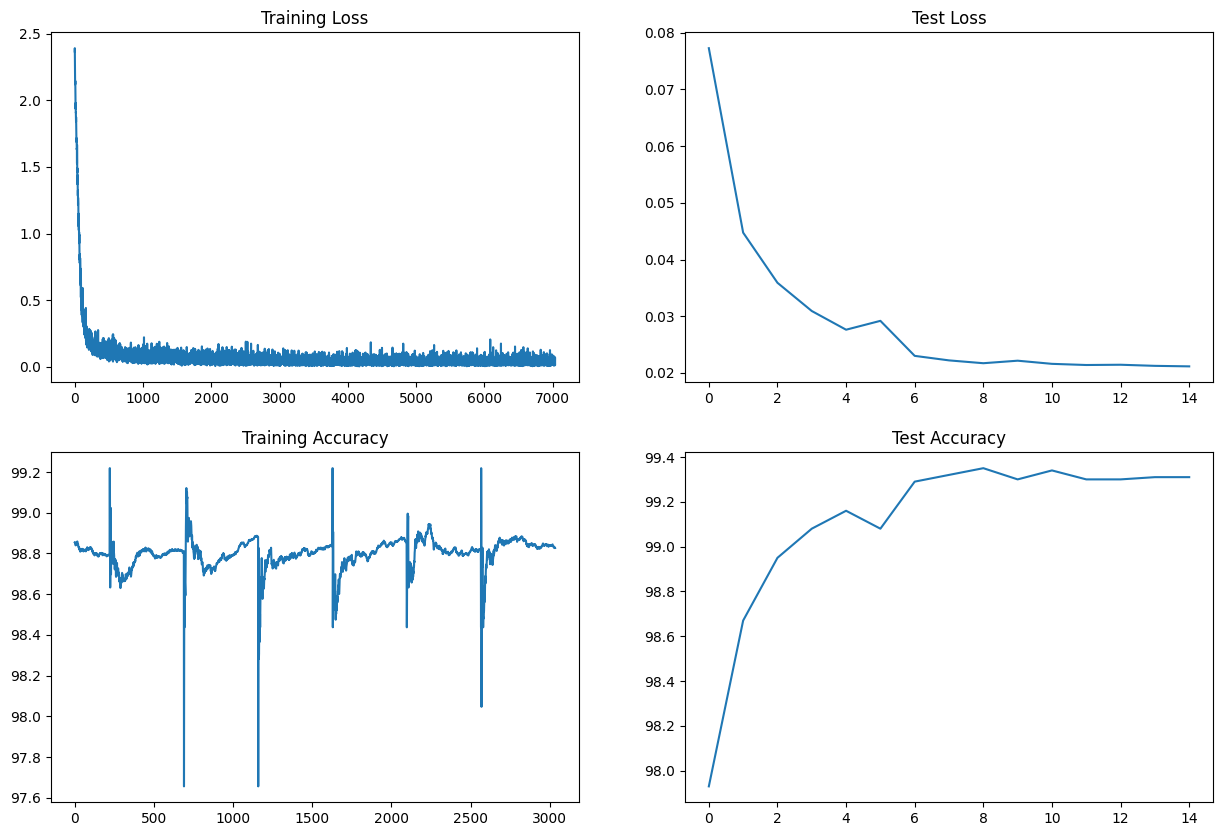

In [9]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")